# Deep Reinforcement Learning:

## Policy Learning

Policy learning involves trying to optimise the policy itself rather than trying to optimise the value function, 

We consider a family of policies: $\pi_\theta : S \to A$, determined by parameter $\theta$ which represents the weights of a neural network. Here we're using a network that maps states into actions and we wish to train the weights to give the optimal policy.

The *fitness* of a policy $\pi_\theta$ is the value function of the initial state $s_0$, ie. the average discounted reward received by the agent if we follow policy $\pi_\theta$:

$$
    \text{fitness}(\pi_\theta) = V^{\pi_\theta}(s_0)=E_{\pi_\theta}(r_{\text{total}})
$$

$E_{\pi_\theta}(r_{\text{total}})$ is the expectation if we follow policy $\pi_\theta$  TODO: Remove?

Policy learning can be done with an *evolution strategy*, like *hill climbing*, or with *policy gradients*.

### Hill Climbing (Evolution Strategy):

We have a network which defines the policy for a particular game.

At any given time, we have a certain set of weights in this network corresponding to a champion (the current best player): $\theta_{\text{champ}} = 0$.

For each trial, we produce a *mutant* by adding random noise to the champion weights: 
$$\theta_{\text{mutant}} = \theta_{\text{champ}} + \text{Gaussian noise},$$ drawn from a normal distribution with some fixed standard deviation $\sigma$.

The mutant is evaluated against the champion on the same task. If the mutant performs better, then we update the champion weights:

$$
    \theta_{\text{champ}} := (1-\alpha)\theta_{\text{champ}} + \alpha \theta_{\text{mutant}},
$$

where $\alpha = 0.1$, for example. If the champion does better than the mutant, then no updating is done.

### Policy Gradients &mdash; Episodic:

Policy gradients is an alternative to the evolution strategy. It uses *gradient ascent* rather than adding random noise weights to produce a better policy.

Suppose we have an agent playing an episodic game. It takes the sequence of actions $a_1, a_2, ..., a_t, ... a_m$ where it receives $r_{\text{total}}$ at the end.

Since we don't have method for determining which actions contributed to the reward, we attribute rewards to each equally.

If $r_{\text{total}}$ is high, the weights of the policy network are changed so that the agent is more likely to take the same actions in the future. We do this by increasing:

$$
    \sum_{t=1}^{m} \log \big( \pi_{\theta} (a_t | s_t) \big) = \log \big( \prod_{t=1}^m \pi_\theta (a_t | s_t) \big), \tag{1}
$$
where $\pi_{\theta} (a_t | s_t)$ is the probability that the policy will choose action $a_t$, given it is at the state $s_t$, and $\prod_{t=1}^m \pi_\theta(a_t | s_t)$ is the probability of the policy choosing a sequence of actions containing $a_1, a_2, ..., a_m$. The policy can compute $\pi_{\theta} (a_t | s_t)$ using Softmax at the output layer.


If $r_{\text{total}}$ is negative, the weights of the policy network are changed so that the agent is less likely to choose the same actions in the future. We do this by decreasing $(1)$.



If we want to increase $(1)$, we can simply multiply the log probability in $(1)$ by $r_{\text{total}}$:

$$
    \triangledown_\theta r_{\text{total}} \sum_{t=1}^m \log \big( \pi_\theta (a_t | s_t) \big) =  r_{\text{total}} \sum_{t=1}^m \triangledown_\theta \log \big( \pi_\theta (a_t | s_t) \big)  \tag{2}
$$

where $\triangledown_\theta \log \big( \pi_\theta (a_t | s_t) \big)$ is the vector of gradients of the log probability with respect to each individual weight $\theta_1,  \theta_2, \ldots, \theta_n$, easily calculated using Softmax.

In general, $\triangledown_y$ means $(\frac{\partial}{\partial y_1}, \frac{\partial}{\partial y_2}, \ldots, \frac{\partial}{\partial y_n})$. The subscript tells you which variable we are differentiating with respect to.

#### Reward/Punishment baseline:
What if the game always gives positive rewards $r_{\text{total}}$, eg. between 4 and 5? Suppose that $r_{\text{total}}=4$ corresponds to a loss. Because the reward is positive, the network will always reward actions even if they contributed to a poor outcome.

If the game always gives positive rewards $r_{\text{total}}$, for example, then we can substitute $r_{\text{total}}$ in $(2)$ to be $r_{\text{total}} - b$, where $b$ is the baseline, eg. $b=4.5$ if the range of values is the interval $[4, 5]$.

#### REINFORCE Algorithm:

The following algorithm has successfully been applied in the earlier reinforcement learning models (1992), eg. for playing Pong, where the image of the game is passed into a convolutional neural network.  

- For each trial:
    - Run the trial and collect the sequence of states $s_t$, actions $a_t$ and the total reward obtained $r_{\text{total}}$ 
    - For $t=1$ to $m$, the length of the trial:
        - $\theta := \theta + \eta(r_{\text{total}} - b) \cdot \triangledown_\theta \log \big ( \pi_\theta (a_t | s_t) \big)$

### Policy Gradients &mdash; Non-Episodic:

Suppose now that rewards can be received at different timesteps throughout the game, rather than only at the completion of the game. 

Suppose you keep a fixed policy $\pi_\theta$ and you play multiple games, each time recording which states $s \in S$ you were in. Every policy $\pi_\theta$ determines a probability distribution $\rho_{\pi_\theta} (s)$ of states $s \in S$:

$$
    \rho_{\pi_\theta} (s) = \sum_{t \geq 0} \gamma^t \text{prob}_{\pi_\theta, t}(s),
$$

where $\text{prob}_{\pi_\theta, t}(s)$ is the probability that after starting in initial state $s_0$, you reach state $s$ after $t$ actions. The value $\rho_{\pi_\theta} (s)$ is the number of times we expect to visit state $s$ if we use policy $\pi_\theta$, discounted by $\gamma^t$.

We can then define the *fitness* of a policy as:

$$
    \text{fitness} (\pi_\theta) = \sum_{s \in S} \big( \rho_{\pi_\theta}(s)\cdot \big( \sum_{a \in A} Q^{\pi_\theta} (s, a) \cdot \pi_\theta (a | s) \big) \big),
$$
and the aim is to maximise the fitness.

Differentiating, we have


$$
\begin{align}
    \triangledown_\theta \text{fitness} (\pi_\theta) &= \sum_{s \in S} \big( \rho_{\pi_\theta}(s)\cdot \big( \sum_{a \in A} Q^{\pi_\theta} (s, a) \cdot \triangledown_\theta \pi_\theta (a | s) \big) \big) \\
    &= \sum_{s \in S} \big( \rho_{\pi_\theta}(s)\cdot \big( \sum_{a \in A} Q^{\pi_\theta} (s, a) \cdot \triangledown_\theta \pi_\theta (a | s) \big) \\
    &= \sum_{s \in S} \big( \rho_{\pi_\theta}(s)\cdot \big( \sum_{a \in A} Q^{\pi_\theta} (s, a) \cdot \pi_\theta (a | s) \cdot \frac{\triangledown_\theta \pi_\theta (a | s)}{\pi_\theta (a | s)} \big) \\
    &= \sum_{s \in S} \big( \rho_{\pi_\theta}(s)\cdot \big( \sum_{a \in A} Q^{\pi_\theta} (s, a) \cdot \pi_\theta (a | s) \cdot \triangledown_\theta \log (\pi_\theta (a | s)) \big) \\
    &= E_{\pi_\theta}\big( Q^{\pi_\theta} (s, a) \cdot \triangledown_\theta \log(\pi_\theta (a | s)) \big). \tag{3}
\end{align}
$$

The gradient of $ \rho_{\pi_\theta}(s)$ and $Q^{\pi_\theta} (s, a)$ are very hard to determine, so only the gradient of $\pi_\theta (a | s)$ is computed

### Actor-Critic Algorithm:

An actor network and a critic network are both learnt together.

In $(3)$, we can't easily find a good estimate for $Q^{\pi_\theta}(s, a)$, so we instead train a network on weights $w$ which determines a Q-function $Q_w$ that aims to approximate/converge towards $Q^{\pi_\theta}$.

Simultaneously, we are also training a network on weights $\theta$ that determines policy $\pi_\theta$.

The actor network takes the current state and produces an action that it believes is best. The critic network takes in the state-action pair and produces a reward, or action score to rate the actor.

Actor-critic tends to take less training time than policy gradient methods.

- For each trial:
    - We are initially on starting state $s_0$. First select the first action $a_0$ from the probability distribution $\pi(a|s_0)$
    - For each timestep $t$:
        - Get reward at this timestep $r_t$ from $R$ 
        - Get the next state $s_{t+1}$ from $\delta$
        - Get the next action $a_{t+1}$ from $\pi$
        - $\frac{dE}{dQ}=-\big( r_t + \gamma Q_w (s_{t+1}, a_{t+1}) - Q_w (s_t, a_t) \big)$
        - $\theta := \theta + \eta_\theta \cdot Q_w (s_t, a_t) \cdot \triangledown_\theta \log(\pi_\theta (a_t|s_t))$
        - $w := w - \eta_w \cdot \frac{dE}{dQ} \cdot \triangledown_w Q_w (s_t, a_t)$ 

### Deep Q-Learning Network for Atari Games:

TODO: Most of this is copied from slides directly. Need to make sure I understand this enough to write in my own words:

<table>
    <tr>
        <td>            
            <img src="images/q-learning-network-atari.png" width="100%">
        </td>
        <td>
            <img src="images/q-learning-network-atari-skeleton.png" width="100%">
        </td>
    <tr>
</table>


The input is the current state of the game and the output is the vector of Q-values associated with each of chosen possible actions.

The goal of the network is to update the weights to move the previous estimate closer to the new estimate.

$$
    \underbrace{Q(s_t, a_t)}_{\text{prev estimate}} := Q(s_t, a_t) + \eta \big(\underbrace{r_t + \gamma \max_{b} Q(s_{t+1})}_{\text{new estimate}} - Q(s_t, a_t) \big)
$$



With a lookup table, Q-learning is guaranteed to converge eventually, however for most applications there are too many states to be reasonably stored in a lookup table.

Instead, we have $Q_w(s, a)$ determined by weights $w$, which get updated so as to minimise the error:

$$
    E = \big( r_t + \gamma \max_{b} Q_w (s_{t+1}, b) - Q_w(s_t, a_t) \big)^2.
$$

Note: gradient is applied only to $Q_w (s_t, a_t),$ not to $Q_w(s_{t+1}, b)$. The Q-value of the next state $s_{t+1}$ is fixed.


#### Deep Q-Learning with Experience Replay:

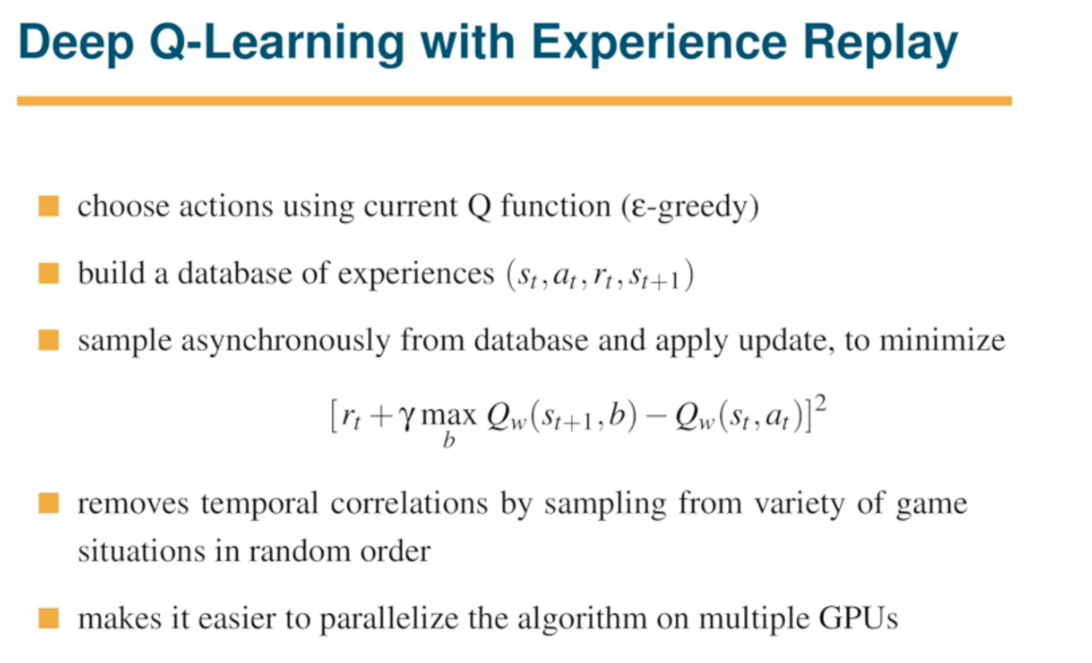

The network is randomly picking different games from the database.

- Prioritised replay &mdash; instead of randomly picking games each with equal probability, pick games according to the greatest DQN error value: 
$$
    E= |r_t + \gamma \max_{b} Q_w (s_{t+1}, b) - Q_w (s_t, a_t)|
$$


- Double Q-Learning mdash; 55:00ish TODO

- Advantage Function &mdash; 58:00ish TODO

### Advantage Actor Critic:

58:00ish